In [1]:
import warnings

warnings.filterwarnings("ignore")

import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import time
from os import path
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import fire

from deepface.basemodels import (
    VGGFace,
    OpenFace,
    Facenet,
    Facenet512,
    FbDeepFace,
    DeepID,
    DlibWrapper,
    ArcFace,
    Boosting,
    SFaceWrapper,
)
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.commons import functions, realtime, distance as dst

import tensorflow as tf

tf_version = int(tf.__version__.split(".")[0])
if tf_version == 2:
    import logging

    tf.get_logger().setLevel(logging.ERROR)

import cv2
import urllib
import numpy as np


## Core functions

In [2]:
def build_model(model_name):

    """
    This function builds a deepface model
    Parameters:
            model_name (string): face recognition or facial attribute model
                    VGG-Face, Facenet, OpenFace, DeepFace, DeepID for face recognition
                    Age, Gender, Emotion, Race for facial attributes

    Returns:
            built deepface model
    """

    global model_obj  # singleton design pattern

    models = {
        "VGG-Face": VGGFace.loadModel,
        "OpenFace": OpenFace.loadModel,
        "Facenet": Facenet.loadModel,
        "Facenet512": Facenet512.loadModel,
        "DeepFace": FbDeepFace.loadModel,
        "DeepID": DeepID.loadModel,
        "Dlib": DlibWrapper.loadModel,
        "ArcFace": ArcFace.loadModel,
        "SFace": SFaceWrapper.load_model,
        "Emotion": Emotion.loadModel,
        "Age": Age.loadModel,
        "Gender": Gender.loadModel,
        "Race": Race.loadModel,
    }

    if not "model_obj" in globals():
        model_obj = {}

    if not model_name in model_obj.keys():
        model = models.get(model_name)
        if model:
            model = model()
            model_obj[model_name] = model
            # print(model_name," built")
        else:
            raise ValueError("Invalid model_name passed - {}".format(model_name))

    return model_obj[model_name]


def analyze(
    img_path,
    actions=("emotion", "age", "gender", "race"),
    models=None,
    enforce_detection=True,
    detector_backend="opencv",
    prog_bar=True,
):

    """
    This function analyzes facial attributes including age, gender, emotion and race

    Parameters:
            img_path: exact image path, numpy array (BGR) or base64 encoded image could be passed. If you are going to analyze lots of images, then set this to list. e.g. img_path = ['img1.jpg', 'img2.jpg']

            actions (tuple): The default is ('age', 'gender', 'emotion', 'race'). You can drop some of those attributes.

            models: (Optional[dict]) facial attribute analysis models are built in every call of analyze function. You can pass pre-built models to speed the function up.

                    models = {}
                    models['age'] = DeepFace.build_model('Age')
                    models['gender'] = DeepFace.build_model('Gender')
                    models['emotion'] = DeepFace.build_model('Emotion')
                    models['race'] = DeepFace.build_model('Race')

            enforce_detection (boolean): The function throws exception if a face could not be detected. Set this to True if you don't want to get exception. This might be convenient for low resolution images.

            detector_backend (string): set face detector backend as retinaface, mtcnn, opencv, ssd or dlib.

            prog_bar (boolean): enable/disable a progress bar
    Returns:
            The function returns a dictionary. If img_path is a list, then it will return list of dictionary.

            {
                    "region": {'x': 230, 'y': 120, 'w': 36, 'h': 45},
                    "age": 28.66,
                    "gender": "woman",
                    "dominant_emotion": "neutral",
                    "emotion": {
                            'sad': 37.65260875225067,
                            'angry': 0.15512987738475204,
                            'surprise': 0.0022171278033056296,
                            'fear': 1.2489334680140018,
                            'happy': 4.609785228967667,
                            'disgust': 9.698561953541684e-07,
                            'neutral': 56.33133053779602
                    }
                    "dominant_race": "white",
                    "race": {
                            'indian': 0.5480832420289516,
                            'asian': 0.7830780930817127,
                            'latino hispanic': 2.0677512511610985,
                            'black': 0.06337375962175429,
                            'middle eastern': 3.088453598320484,
                            'white': 93.44925880432129
                    }
            }

    """

    actions = list(actions)
    if not models:
        models = {}

    img_paths, bulkProcess = functions.initialize_input(img_path)

    # ---------------------------------

    built_models = list(models.keys())

    # ---------------------------------

    # pre-trained models passed but it doesn't exist in actions
    if len(built_models) > 0:
        if "emotion" in built_models and "emotion" not in actions:
            actions.append("emotion")

        if "age" in built_models and "age" not in actions:
            actions.append("age")

        if "gender" in built_models and "gender" not in actions:
            actions.append("gender")

        if "race" in built_models and "race" not in actions:
            actions.append("race")

    # ---------------------------------

    if "emotion" in actions and "emotion" not in built_models:
        models["emotion"] = build_model("Emotion")

    if "age" in actions and "age" not in built_models:
        models["age"] = build_model("Age")

    if "gender" in actions and "gender" not in built_models:
        models["gender"] = build_model("Gender")

    if "race" in actions and "race" not in built_models:
        models["race"] = build_model("Race")

    # ---------------------------------

    resp_objects = []

    disable_option = (False if len(img_paths) > 1 else True) or not prog_bar

    global_pbar = tqdm(
        range(0, len(img_paths)), desc="Analyzing", disable=disable_option
    )

    for j in global_pbar:
        img_path = img_paths[j]

        resp_obj = {}

        disable_option = (False if len(actions) > 1 else True) or not prog_bar

        pbar = tqdm(
            range(0, len(actions)), desc="Finding actions", disable=disable_option
        )

        img_224 = None  # Set to prevent re-detection

        region = []  # x, y, w, h of the detected face region
        region_labels = ["x", "y", "w", "h"]

        is_region_set = False

        # facial attribute analysis
        for index in pbar:
            action = actions[index]
            pbar.set_description("Action: %s" % (action))

            if action == "emotion":
                emotion_labels = [
                    "angry",
                    "disgust",
                    "fear",
                    "happy",
                    "sad",
                    "surprise",
                    "neutral",
                ]
                img, region = functions.preprocess_face(
                    img=img_path,
                    target_size=(48, 48),
                    grayscale=True,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    return_region=True,
                )

                emotion_predictions = models["emotion"].predict(img)[0, :]

                sum_of_predictions = emotion_predictions.sum()

                resp_obj["emotion"] = {}

                for i in range(0, len(emotion_labels)):
                    emotion_label = emotion_labels[i]
                    emotion_prediction = (
                        100 * emotion_predictions[i] / sum_of_predictions
                    )
                    resp_obj["emotion"][emotion_label] = emotion_prediction

                resp_obj["dominant_emotion"] = emotion_labels[
                    np.argmax(emotion_predictions)
                ]

            elif action == "age":
                if img_224 is None:
                    img_224, region = functions.preprocess_face(
                        img=img_path,
                        target_size=(224, 224),
                        grayscale=False,
                        enforce_detection=enforce_detection,
                        detector_backend=detector_backend,
                        return_region=True,
                    )

                age_predictions = models["age"].predict(img_224)[0, :]
                apparent_age = Age.findApparentAge(age_predictions)

                resp_obj["age"] = int(
                    apparent_age
                )  # int cast is for the exception - object of type 'float32' is not JSON serializable

            elif action == "gender":
                if img_224 is None:
                    img_224, region = functions.preprocess_face(
                        img=img_path,
                        target_size=(224, 224),
                        grayscale=False,
                        enforce_detection=enforce_detection,
                        detector_backend=detector_backend,
                        return_region=True,
                    )

                gender_prediction = models["gender"].predict(img_224)[0, :]

                if np.argmax(gender_prediction) == 0:
                    gender = "Woman"
                elif np.argmax(gender_prediction) == 1:
                    gender = "Man"

                resp_obj["gender"] = gender

            elif action == "race":
                if img_224 is None:
                    img_224, region = functions.preprocess_face(
                        img=img_path,
                        target_size=(224, 224),
                        grayscale=False,
                        enforce_detection=enforce_detection,
                        detector_backend=detector_backend,
                        return_region=True,
                    )  # just emotion model expects grayscale images
                race_predictions = models["race"].predict(img_224)[0, :]
                race_labels = [
                    "asian",
                    "indian",
                    "black",
                    "white",
                    "middle eastern",
                    "latino hispanic",
                ]

                sum_of_predictions = race_predictions.sum()

                resp_obj["race"] = {}
                for i in range(0, len(race_labels)):
                    race_label = race_labels[i]
                    race_prediction = 100 * race_predictions[i] / sum_of_predictions
                    resp_obj["race"][race_label] = race_prediction

                resp_obj["dominant_race"] = race_labels[np.argmax(race_predictions)]

            # -----------------------------

            if is_region_set != True:
                resp_obj["region"] = {}
                is_region_set = True
                for i, parameter in enumerate(region_labels):
                    resp_obj["region"][parameter] = int(
                        region[i]
                    )  # int cast is for the exception - object of type 'float32' is not JSON serializable

        # ---------------------------------

        if bulkProcess == True:
            resp_objects.append(resp_obj)
        else:
            return resp_obj

    if bulkProcess == True:

        resp_obj = {}

        for i in range(0, len(resp_objects)):
            resp_item = resp_objects[i]
            resp_obj["instance_%d" % (i + 1)] = resp_item

        return resp_obj


def find(
    img_path,
    db_path,
    model_name="VGG-Face",
    distance_metric="cosine",
    model=None,
    enforce_detection=True,
    detector_backend="opencv",
    align=True,
    prog_bar=True,
    normalization="base",
    silent=False,
):

    """
    This function applies verification several times and find an identity in a database

    Parameters:
            img_path: exact image path, numpy array (BGR) or based64 encoded image. If you are going to find several identities, then you should pass img_path as array instead of calling find function in a for loop. e.g. img_path = ["img1.jpg", "img2.jpg"]

            db_path (string): You should store some .jpg files in a folder and pass the exact folder path to this.

            model_name (string): VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib or Ensemble

            distance_metric (string): cosine, euclidean, euclidean_l2

            model: built deepface model. A face recognition models are built in every call of find function. You can pass pre-built models to speed the function up.

                    model = DeepFace.build_model('VGG-Face')

            enforce_detection (boolean): The function throws exception if a face could not be detected. Set this to True if you don't want to get exception. This might be convenient for low resolution images.

            detector_backend (string): set face detector backend as retinaface, mtcnn, opencv, ssd or dlib

            prog_bar (boolean): enable/disable a progress bar

    Returns:
            This function returns pandas data frame. If a list of images is passed to img_path, then it will return list of pandas data frame.
    """

    tic = time.time()

    img_paths, bulkProcess = functions.initialize_input(img_path)

    # -------------------------------

    if os.path.isdir(db_path) == True:

        if model == None:

            if model_name == "Ensemble":
                if not silent:
                    print("Ensemble learning enabled")
                models = Boosting.loadModel()

            else:  # model is not ensemble
                model = build_model(model_name)
                models = {}
                models[model_name] = model

        else:  # model != None
            if not silent:
                print("Already built model is passed")

            if model_name == "Ensemble":
                Boosting.validate_model(model)
                models = model.copy()
            else:
                models = {}
                models[model_name] = model

        # ---------------------------------------

        if model_name == "Ensemble":
            model_names = ["VGG-Face", "Facenet", "OpenFace", "DeepFace"]
            metric_names = ["cosine", "euclidean", "euclidean_l2"]
        elif model_name != "Ensemble":
            model_names = []
            metric_names = []
            model_names.append(model_name)
            metric_names.append(distance_metric)

        # ---------------------------------------

        file_name = "representations_%s.pkl" % (model_name)
        file_name = file_name.replace("-", "_").lower()

        if path.exists(db_path + "/" + file_name):

            if not silent:
                print(
                    "WARNING: Representations for images in ",
                    db_path,
                    " folder were previously stored in ",
                    file_name,
                    ". If you added new instances after this file creation, then please delete this file and call find function again. It will create it again.",
                )

            f = open(db_path + "/" + file_name, "rb")
            representations = pickle.load(f)

            if not silent:
                print(
                    "There are ",
                    len(representations),
                    " representations found in ",
                    file_name,
                )

        else:  # create representation.pkl from scratch
            employees = []

            for r, d, f in os.walk(db_path):  # r=root, d=directories, f = files
                for file in f:
                    if (".jpg" in file.lower()) or (".png" in file.lower()):
                        exact_path = r + "/" + file
                        employees.append(exact_path)

            if len(employees) == 0:
                raise ValueError(
                    "There is no image in ",
                    db_path,
                    " folder! Validate .jpg or .png files exist in this path.",
                )

            # ------------------------
            # find representations for db images

            representations = []

            pbar = tqdm(
                range(0, len(employees)),
                desc="Finding representations",
                disable=prog_bar,
            )

            # for employee in employees:
            for index in pbar:
                employee = employees[index]

                instance = []
                instance.append(employee)

                for j in model_names:
                    custom_model = models[j]

                    representation = represent(
                        img_path=employee,
                        model_name=model_name,
                        model=custom_model,
                        enforce_detection=enforce_detection,
                        detector_backend=detector_backend,
                        align=align,
                        normalization=normalization,
                    )

                    instance.append(representation)

                # -------------------------------

                representations.append(instance)

            f = open(db_path + "/" + file_name, "wb")
            pickle.dump(representations, f)
            f.close()

            if not silent:
                print(
                    "Representations stored in ",
                    db_path,
                    "/",
                    file_name,
                    " file. Please delete this file when you add new identities in your database.",
                )

        # ----------------------------
        # now, we got representations for facial database

        if model_name != "Ensemble":
            df = pd.DataFrame(
                representations,
                columns=["identity", "%s_representation" % (model_name)],
            )
        else:  # ensemble learning

            columns = ["identity"]
            [columns.append("%s_representation" % i) for i in model_names]

            df = pd.DataFrame(representations, columns=columns)

        df_base = (
            df.copy()
        )  # df will be filtered in each img. we will restore it for the next item.

        resp_obj = []

        global_pbar = tqdm(range(0, len(img_paths)), desc="Analyzing", disable=prog_bar)
        for j in global_pbar:
            img_path = img_paths[j]

            # find representation for passed image

            for j in model_names:
                custom_model = models[j]

                target_representation = represent(
                    img_path=img_path,
                    model_name=model_name,
                    model=custom_model,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    align=align,
                    normalization=normalization,
                )

                for k in metric_names:
                    distances = []
                    for index, instance in df.iterrows():
                        source_representation = instance["%s_representation" % (j)]

                        if k == "cosine":
                            distance = dst.findCosineDistance(
                                source_representation, target_representation
                            )
                        elif k == "euclidean":
                            distance = dst.findEuclideanDistance(
                                source_representation, target_representation
                            )
                        elif k == "euclidean_l2":
                            distance = dst.findEuclideanDistance(
                                dst.l2_normalize(source_representation),
                                dst.l2_normalize(target_representation),
                            )

                        distances.append(distance)

                    # ---------------------------

                    if (
                        model_name == "Ensemble"
                        and j == "OpenFace"
                        and k == "euclidean"
                    ):
                        continue
                    else:
                        df["%s_%s" % (j, k)] = distances

                        if model_name != "Ensemble":
                            threshold = dst.findThreshold(j, k)
                            df = df.drop(columns=["%s_representation" % (j)])
                            df = df[df["%s_%s" % (j, k)] <= threshold]

                            df = df.sort_values(
                                by=["%s_%s" % (j, k)], ascending=True
                            ).reset_index(drop=True)

                            resp_obj.append(df)
                            df = df_base.copy()  # restore df for the next iteration

            # ----------------------------------

            if model_name == "Ensemble":

                feature_names = []
                for j in model_names:
                    for k in metric_names:
                        if (
                            model_name == "Ensemble"
                            and j == "OpenFace"
                            and k == "euclidean"
                        ):
                            continue
                        else:
                            feature = "%s_%s" % (j, k)
                            feature_names.append(feature)

                # print(df.head())

                x = df[feature_names].values

                # --------------------------------------

                boosted_tree = Boosting.build_gbm()

                y = boosted_tree.predict(x)

                verified_labels = []
                scores = []
                for i in y:
                    verified = np.argmax(i) == 1
                    score = i[np.argmax(i)]

                    verified_labels.append(verified)
                    scores.append(score)

                df["verified"] = verified_labels
                df["score"] = scores

                df = df[df.verified == True]
                # df = df[df.score > 0.99] #confidence score
                df = df.sort_values(by=["score"], ascending=False).reset_index(
                    drop=True
                )
                df = df[["identity", "verified", "score"]]

                resp_obj.append(df)
                df = df_base.copy()  # restore df for the next iteration

            # ----------------------------------

        toc = time.time()

        if not silent:
            print("find function lasts ", toc - tic, " seconds")

        if len(resp_obj) == 1:
            return resp_obj[0]

        return resp_obj

    else:
        raise ValueError("Passed db_path does not exist!")

    return None


def represent(
    img_path,
    model_name="VGG-Face",
    model=None,
    enforce_detection=True,
    detector_backend="opencv",
    align=True,
    normalization="base",
):

    """
    This function represents facial images as vectors.

    Parameters:
            img_path: exact image path, numpy array (BGR) or based64 encoded images could be passed.

            model_name (string): VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib, ArcFace.

            model: Built deepface model. A face recognition model is built every call of verify function. You can pass pre-built face recognition model optionally if you will call verify function several times. Consider to pass model if you are going to call represent function in a for loop.

                    model = DeepFace.build_model('VGG-Face')

            enforce_detection (boolean): If any face could not be detected in an image, then verify function will return exception. Set this to False not to have this exception. This might be convenient for low resolution images.

            detector_backend (string): set face detector backend as retinaface, mtcnn, opencv, ssd or dlib

            normalization (string): normalize the input image before feeding to model

    Returns:
            Represent function returns a multidimensional vector. The number of dimensions is changing based on the reference model. E.g. FaceNet returns 128 dimensional vector; VGG-Face returns 2622 dimensional vector.
    """

    if model is None:
        model = build_model(model_name)

    # ---------------------------------

    # decide input shape
    input_shape_x, input_shape_y = functions.find_input_shape(model)

    # detect and align
    img = functions.preprocess_face(
        img=img_path,
        target_size=(input_shape_y, input_shape_x),
        enforce_detection=enforce_detection,
        detector_backend=detector_backend,
        align=align,
    )

    # ---------------------------------
    # custom normalization

    img = functions.normalize_input(img=img, normalization=normalization)

    # ---------------------------------

    # represent
    embedding = model.predict(img)[0].tolist()

    return embedding


def stream(
    db_path="",
    model_name="VGG-Face",
    detector_backend="opencv",
    distance_metric="cosine",
    enable_face_analysis=True,
    source=0,
    time_threshold=5,
    frame_threshold=5,
):

    """
    This function applies real time face recognition and facial attribute analysis

    Parameters:
            db_path (string): facial database path. You should store some .jpg files in this folder.

            model_name (string): VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib or Ensemble

            detector_backend (string): opencv, ssd, mtcnn, dlib, retinaface

            distance_metric (string): cosine, euclidean, euclidean_l2

            enable_facial_analysis (boolean): Set this to False to just run face recognition

            source: Set this to 0 for access web cam. Otherwise, pass exact video path.

            time_threshold (int): how many second analyzed image will be displayed

            frame_threshold (int): how many frames required to focus on face

    """

    if time_threshold < 1:
        raise ValueError(
            "time_threshold must be greater than the value 1 but you passed "
            + str(time_threshold)
        )

    if frame_threshold < 1:
        raise ValueError(
            "frame_threshold must be greater than the value 1 but you passed "
            + str(frame_threshold)
        )

    realtime.analysis(
        db_path,
        model_name,
        detector_backend,
        distance_metric,
        enable_face_analysis,
        source=source,
        time_threshold=time_threshold,
        frame_threshold=frame_threshold,
    )


def detectFace(
    img_path,
    target_size=(224, 224),
    detector_backend="opencv",
    enforce_detection=True,
    align=True,
):

    """
    This function applies pre-processing stages of a face recognition pipeline including detection and alignment

    Parameters:
            img_path: exact image path, numpy array (BGR) or base64 encoded image

            detector_backend (string): face detection backends are retinaface, mtcnn, opencv, ssd or dlib

    Returns:
            deteced and aligned face in numpy format
    """

    img = functions.preprocess_face(
        img=img_path,
        target_size=target_size,
        detector_backend=detector_backend,
        enforce_detection=enforce_detection,
        align=align,
    )[
        0
    ]  # preprocess_face returns (1, 224, 224, 3)
    return img[:, :, ::-1]  # bgr to rgb


# ---------------------------
# main

functions.initialize_folder()


def cli():
    fire.Fire()


In [3]:
import numpy as np
import urllib.request
import cv2
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	return image

In [4]:
def verify(
    img1_path,
    img2_path="",
    model_name="VGG-Face",
    distance_metric="cosine",
    model=None,
    enforce_detection=True,
    detector_backend="opencv",
    align=True,
    prog_bar=True,
    normalization="base",
):

    """
    This function verifies an image pair is same person or different persons.

    Parameters:
            img1_path, img2_path: exact image path, numpy array (BGR) or based64 encoded images could be passed. If you are going to call verify function for a list of image pairs, then you should pass an array instead of calling the function in for loops.

            e.g. img1_path = [
                    ['img1.jpg', 'img2.jpg'],
                    ['img2.jpg', 'img3.jpg']
            ]

            model_name (string): VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib, ArcFace or Ensemble

            distance_metric (string): cosine, euclidean, euclidean_l2

            model: Built deepface model. A face recognition model is built every call of verify function. You can pass pre-built face recognition model optionally if you will call verify function several times.

                    model = DeepFace.build_model('VGG-Face')

            enforce_detection (boolean): If any face could not be detected in an image, then verify function will return exception. Set this to False not to have this exception. This might be convenient for low resolution images.

            detector_backend (string): set face detector backend as retinaface, mtcnn, opencv, ssd or dlib

            prog_bar (boolean): enable/disable a progress bar

    Returns:
            Verify function returns a dictionary. If img1_path is a list of image pairs, then the function will return list of dictionary.

            {
                    "verified": True
                    , "distance": 0.2563
                    , "max_threshold_to_verify": 0.40
                    , "model": "VGG-Face"
                    , "similarity_metric": "cosine"
            }

    """

    tic = time.time()

    img_list, bulkProcess = functions.initialize_input(img1_path, img2_path)

    resp_objects = []

    # --------------------------------

    if model_name == "Ensemble":
        model_names = ["VGG-Face", "Facenet", "OpenFace", "DeepFace"]
        metrics = ["cosine", "euclidean", "euclidean_l2"]
    else:
        model_names = []
        metrics = []
        model_names.append(model_name)
        metrics.append(distance_metric)

    # --------------------------------

    if model == None:
        if model_name == "Ensemble":
            models = Boosting.loadModel()
        else:
            model = build_model(model_name)
            models = {}
            models[model_name] = model
    else:
        if model_name == "Ensemble":
            Boosting.validate_model(model)
            models = model.copy()
        else:
            models = {}
            models[model_name] = model

    # ------------------------------

    disable_option = (False if len(img_list) > 1 else True) or not prog_bar

    pbar = tqdm(range(0, len(img_list)), desc="Verification", disable=disable_option)

    for index in pbar:

        instance = img_list[index]

        if type(instance) == list and len(instance) >= 2:
            img1_path = instance[0]
            img2_path = instance[1]

            ensemble_features = []

            for i in model_names:
                custom_model = models[i]

                # img_path, model_name = 'VGG-Face', model = None, enforce_detection = True, detector_backend = 'mtcnn'
                img1_representation = represent(
                    img_path=img1_path,
                    model_name=model_name,
                    model=custom_model,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    align=align,
                    normalization=normalization,
                )
                print("Shape of #1 embedding:",len(img1_representation))
                img2_representation = represent(
                    img_path=img2_path,
                    model_name=model_name,
                    model=custom_model,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    align=align,
                    normalization=normalization,
                )
                print("Shape of #2 embedding:",len(img2_representation))

                # ----------------------
                # find distances between embeddings

                for j in metrics:

                    if j == "cosine":
                        distance = dst.findCosineDistance(
                            img1_representation, img2_representation
                        )
                    elif j == "euclidean":
                        distance = dst.findEuclideanDistance(
                            img1_representation, img2_representation
                        )
                    elif j == "euclidean_l2":
                        distance = dst.findEuclideanDistance(
                            dst.l2_normalize(img1_representation),
                            dst.l2_normalize(img2_representation),
                        )
                    else:
                        raise ValueError(
                            "Invalid distance_metric passed - ", distance_metric
                        )

                    distance = np.float64(
                        distance
                    )  # causes trobule for euclideans in api calls if this is not set (issue #175)
                    # ----------------------
                    # decision

                    if model_name != "Ensemble":

                        threshold = dst.findThreshold(i, j)

                        if distance <= threshold:
                            identified = True
                        else:
                            identified = False

                        resp_obj = {
                            "verified": identified,
                            "distance": distance,
                            "threshold": threshold,
                            "model": model_name,
                            "detector_backend": detector_backend,
                            "similarity_metric": distance_metric,
                        }

                        if bulkProcess == True:
                            resp_objects.append(resp_obj)
                        else:
                            return resp_obj

                    else:  # Ensemble

                        # this returns same with OpenFace - euclidean_l2
                        if i == "OpenFace" and j == "euclidean":
                            continue
                        else:
                            ensemble_features.append(distance)

            # ----------------------

            if model_name == "Ensemble":

                boosted_tree = Boosting.build_gbm()

                prediction = boosted_tree.predict(
                    np.expand_dims(np.array(ensemble_features), axis=0)
                )[0]

                verified = np.argmax(prediction) == 1
                score = prediction[np.argmax(prediction)]

                resp_obj = {
                    "verified": verified,
                    "score": score,
                    "distance": ensemble_features,
                    "model": ["VGG-Face", "Facenet", "OpenFace", "DeepFace"],
                    "similarity_metric": ["cosine", "euclidean", "euclidean_l2"],
                }

                if bulkProcess == True:
                    resp_objects.append(resp_obj)
                else:
                    return resp_obj

            # ----------------------

        else:
            raise ValueError("Invalid arguments passed to verify function: ", instance)

    # -------------------------

    toc = time.time()

    if bulkProcess == True:

        resp_obj = {}

        for i in range(0, len(resp_objects)):
            resp_item = resp_objects[i]
            resp_obj["pair_%d" % (i + 1)] = resp_item

        return resp_obj

def get_embeddings(
    img1_path,
    img2_path="",
    model_name="VGG-Face",
    distance_metric="cosine",
    model=None,
    enforce_detection=True,
    detector_backend="opencv",
    align=True,
    prog_bar=True,
    normalization="base",
):

    """
    This function verifies an image pair is same person or different persons.

    Parameters:
            img1_path, img2_path: exact image path, numpy array (BGR) or based64 encoded images could be passed. If you are going to call verify function for a list of image pairs, then you should pass an array instead of calling the function in for loops.

            e.g. img1_path = [
                    ['img1.jpg', 'img2.jpg'],
                    ['img2.jpg', 'img3.jpg']
            ]

            model_name (string): VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib, ArcFace or Ensemble

            distance_metric (string): cosine, euclidean, euclidean_l2

            model: Built deepface model. A face recognition model is built every call of verify function. You can pass pre-built face recognition model optionally if you will call verify function several times.

                    model = DeepFace.build_model('VGG-Face')

            enforce_detection (boolean): If any face could not be detected in an image, then verify function will return exception. Set this to False not to have this exception. This might be convenient for low resolution images.

            detector_backend (string): set face detector backend as retinaface, mtcnn, opencv, ssd or dlib

            prog_bar (boolean): enable/disable a progress bar

    Returns:
            Verify function returns a dictionary. If img1_path is a list of image pairs, then the function will return list of dictionary.

            {
                    "verified": True
                    , "distance": 0.2563
                    , "max_threshold_to_verify": 0.40
                    , "model": "VGG-Face"
                    , "similarity_metric": "cosine"
            }

    """

    tic = time.time()

    img_list, bulkProcess = functions.initialize_input(img1_path, img2_path)

    resp_objects = []
    embeddings = []

    # --------------------------------

    if model_name == "Ensemble":
        model_names = ["VGG-Face", "Facenet", "OpenFace", "DeepFace"]
        metrics = ["cosine", "euclidean", "euclidean_l2"]
    else:
        model_names = []
        metrics = []
        model_names.append(model_name)
        metrics.append(distance_metric)

    # --------------------------------

    if model == None:
        if model_name == "Ensemble":
            models = Boosting.loadModel()
        else:
            model = build_model(model_name)
            models = {}
            models[model_name] = model
    else:
        if model_name == "Ensemble":
            Boosting.validate_model(model)
            models = model.copy()
        else:
            models = {}
            models[model_name] = model

    # ------------------------------

    disable_option = (False if len(img_list) > 1 else True) or not prog_bar

    pbar = tqdm(range(0, len(img_list)), desc="Verification", disable=disable_option)

    for index in pbar:

        instance = img_list[index]

        if type(instance) == list and len(instance) >= 2:
            img1_path = instance[0]
            img2_path = instance[1]

            ensemble_features = []

            for i in model_names:
                custom_model = models[i]

                # img_path, model_name = 'VGG-Face', model = None, enforce_detection = True, detector_backend = 'mtcnn'
                img1_representation = represent(
                    img_path=img1_path,
                    model_name=model_name,
                    model=custom_model,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    align=align,
                    normalization=normalization,
                )
                # print("Shape of #1 embedding:",len(img1_representation))
                img2_representation = represent(
                    img_path=img2_path,
                    model_name=model_name,
                    model=custom_model,
                    enforce_detection=enforce_detection,
                    detector_backend=detector_backend,
                    align=align,
                    normalization=normalization,
                )
                # print("Shape of #2 embedding:",len(img2_representation))
                embeddings.append(img1_representation)
                embeddings.append(img2_representation)
        else:
            raise ValueError("Invalid arguments passed to verify function: ", instance)

    # -------------------------

    toc = time.time()

    embeddings = np.array(embeddings)
    return embeddings


### Getting image by URL

In [5]:
url_tarantino = "https://img.20mn.fr/8aUPynXMTlCiD9wgR4lN7yk/1200x768_realisateur-quentin-tarantino"
url_tarantino2 = "https://media.npr.org/assets/artslife/movies/2009/08/tarantinofa-3b0dc6eaf870250bc12b177cf7543928bd897725.jpg"

img_tarantino = url_to_image(url_tarantino)
img_tarantino2 = url_to_image(url_tarantino2)

# SHOW IMG BY URL
# cv2.imshow("Image", img_tarantino)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

img1 = img_tarantino2
img2 = img_tarantino

### Getting image from local file

In [6]:
# OLEG
# img1=cv2.imread('/home/besmaks/Pictures/Oleg.jpg')
# img1=cv2.imread('/home/besmaks/Pictures/Oleg2.jpg')
# img2=cv2.imread('/home/besmaks/Pictures/Oleg2.jpg')

# MAKS
# img1=cv2.imread('/home/besmaks/Pictures/Maks1.jpg')
# img2=cv2.imread('/home/besmaks/Pictures/Maks2.jpg')
# img1=cv2.imread('/home/besmaks/Pictures/Maks3.jpg')

# NIKITA
# img1 = cv2.imread('/home/besmaks/Pictures/Nikitos.png')
# img2 = cv2.imread('/home/besmaks/Pictures/Nikitos.png')

# VOVA
# img2 = cv2.imread('/home/besmaks/Pictures/Vova.png')


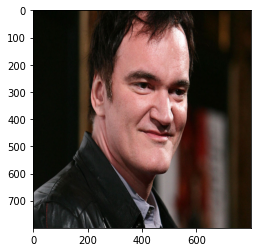

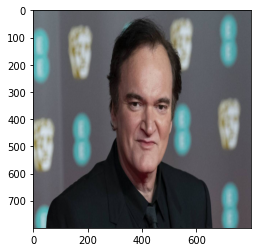

In [7]:
new_width = 800
new_height = 800

# dsize
dsize = (new_width, new_height)

# resize image
img1 = cv2.resize(img1, dsize)
img2 = cv2.resize(img2, dsize, interpolation = cv2.INTER_AREA)

plt.figure()
plt.imshow(img1[:,:,::-1])
plt.figure()
plt.imshow(img2[:,:,::-1])

### Embedding show

In [8]:
# result = verify(img1, img2)
# print("The same person?\t", result["verified"])
# print("Distance [0;1]:\t\t", result["distance"])

result = get_embeddings(img1, img2)
print("#1 embedding:", result[0])
print("#2 embedding:", result[1])

#1 embedding: [ 0.0038467   0.0021535   0.01857714 ... -0.02062535  0.0046287
  0.0026891 ]
#2 embedding: [ 0.01042779  0.00297266  0.00754164 ... -0.00324604 -0.0052989
 -0.00264201]
